In [9]:
import numpy as np

import matplotlib.pyplot as plt

import time

from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.util import norm
from poliastro.constants import R_earth
from poliastro.core.elements import coe2rv
from poliastro.twobody.sampling import EpochsArray
from poliastro.twobody.propagation import CowellPropagator

from astropy import units as u
from astropy.time import Time, TimeDelta

from datetime import datetime, timedelta
from sso_inc import inc_from_alt, raan_from_ltan,angle_between

# import sys
# sys.path.append('../my_scripts')

from perturbations import pertubations_coesa_high, pertubations_coesa_low

toc = time.time()
## Orbit
h = 300
start_date = datetime(2024,1,1,9,0,0)
ltan = 22.5

a = (R_earth.value/1000 + h) << u.km
ecc = 1e-6 << u.one
inc = inc_from_alt(h,ecc)[0] << u.deg   
raan = raan_from_ltan(Time(val=datetime.timestamp(start_date), format='unix'),ltan) << u.deg
argp = 1e-6 << u.deg
nu = 1e-6 << u.deg

epoch = Time(val=start_date.isoformat(), format='isot')

reference_orbit = Orbit.from_classical(
    Earth,
    a,
    ecc,
    inc,
    raan,
    argp,
    nu,
    epoch
    )
trailing_orbit = Orbit.from_classical(
    Earth,
    a+(2<<u.km),
    ecc,
    inc,
    raan,
    argp,
    nu+(0<<u.deg),
    epoch
    )


time_step = 3600<<u.s

refsmalist = []
trailsmalist = []

assignment = 10

ref_vel = []
trail_vel = []

elapsedsecs = []
secs = 0

rmag_ref = []
rmag_trail = []

vmag_ref = []
vmag_trail = []

angle_list = []
ang_vel_list = []

theta_err_list = []

maneuvers = 0

#for timestamp in range(len(timestamps)):
start_date_prop = epoch

while secs < 60*60*24*150:
    
    maneuvers += 1

    if trailing_orbit.n.value < reference_orbit.n.value:

        reference_leader = True
        # theta_err = 10 - reference_orbit.nu.to_value(u.deg)
        theta_err = 350 - angle_between(trailing_orbit.r.value, reference_orbit.r.value)
        #theta_err = reference_orbit.nu.to_value(u.deg) - trailing_orbit.nu.to_value(u.deg) + 10
        tra_orb_10days = trailing_orbit.propagate(10<<u.day, method=CowellPropagator(rtol=1e-5, f=pertubations_coesa_high))
        theta_dot_dot = (tra_orb_10days.n.to_value(u.deg/u.s) - trailing_orbit.n.to_value(u.deg/u.s)) / (10*24*60*60)
        t_hd = (reference_orbit.n.to_value(u.deg/u.s) - trailing_orbit.n.to_value(u.deg/u.s)) / theta_dot_dot
        theta_hd = 0.5 * theta_dot_dot * t_hd**2
        t_wait = np.abs(theta_hd - theta_err) / (reference_orbit.n.to_value(u.deg/u.s) - trailing_orbit.n.to_value(u.deg/u.s))

    else:
        reference_leader = False
        # theta_err = 10 - reference_orbit.nu.to_value(u.deg)
        theta_err = 350 - angle_between(reference_orbit.r.value, trailing_orbit.r.value)
        #theta_err = reference_orbit.nu.to_value(u.deg) - trailing_orbit.nu.to_value(u.deg) + 10
        ref_orb_10days = reference_orbit.propagate(10<<u.day, method=CowellPropagator(rtol=1e-5, f=pertubations_coesa_high))
        theta_dot_dot = (ref_orb_10days.n.to_value(u.deg/u.s) - reference_orbit.n.to_value(u.deg/u.s)) / (10*24*60*60)
        t_hd = (trailing_orbit.n.to_value(u.deg/u.s) - reference_orbit.n.to_value(u.deg/u.s)) / theta_dot_dot
        theta_hd = 0.5 * theta_dot_dot * t_hd**2
        t_wait = np.abs(theta_hd - theta_err) / (trailing_orbit.n.to_value(u.deg/u.s) - reference_orbit.n.to_value(u.deg/u.s))
        

    num_wait = int(t_wait / time_step.value)
    tofs_wait = TimeDelta(np.linspace(0, t_wait<<u.s, num=num_wait))
    reference_ephem = reference_orbit.to_ephem(EpochsArray(start_date_prop + tofs_wait, method=CowellPropagator(rtol=1e-5, f=pertubations_coesa_low)))
    trailing_ephem = trailing_orbit.to_ephem(EpochsArray(start_date_prop + tofs_wait, method=CowellPropagator(rtol=1e-5, f=pertubations_coesa_low)))

    for t in range(len(tofs_wait)):

        secs += time_step.value

        refsmalist.append(Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t]).a.value)
        trailsmalist.append(Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t]).a.value)

        rmag_ref.append(np.linalg.norm(Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t]).r.value))
        rmag_trail.append(np.linalg.norm(Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t]).r.value))  

        vmag_ref.append(np.linalg.norm(Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t]).v.value))
        vmag_trail.append(np.linalg.norm(Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t]).v.value))
        
        angle_list.append(angle_between(Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t]).r.value, Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t]).r.value))
        # angle_list.append((Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t]).nu.to_value(u.deg)) - Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t]).nu.value)

        ang_vel_ref = (360 << u.deg) / Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t]).period
        ang_vel_trail = (360 <<u.deg) / Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t]).period
        ang_vel_diff =  ang_vel_ref - ang_vel_trail
        ang_vel_list.append(ang_vel_diff.value)

        elapsedsecs.append(secs)
    
    reference_orbit = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[-1])
    trailing_orbit = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[-1])

    num_hd = int(t_hd / time_step.value)
    tofs_hd = TimeDelta(np.linspace(0, t_hd<<u.s, num=num_hd))

    if reference_leader:
        reference_ephem = reference_orbit.to_ephem(EpochsArray(reference_ephem.epochs[-1] + tofs_hd, method=CowellPropagator(rtol=1e-5, f=pertubations_coesa_low)))
        trailing_ephem = trailing_orbit.to_ephem(EpochsArray(trailing_ephem.epochs[-1] + tofs_hd, method=CowellPropagator(rtol=1e-5, f=pertubations_coesa_high)))
    else:
        reference_ephem = reference_orbit.to_ephem(EpochsArray(reference_ephem.epochs[-1] + tofs_hd, method=CowellPropagator(rtol=1e-5, f=pertubations_coesa_high)))
        trailing_ephem = trailing_orbit.to_ephem(EpochsArray(trailing_ephem.epochs[-1] + tofs_hd, method=CowellPropagator(rtol=1e-5, f=pertubations_coesa_low)))

    for t in range(len(tofs_hd)):

        secs += time_step.value

        refsmalist.append(Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t]).a.value)
        trailsmalist.append(Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t]).a.value)

        rmag_ref.append(np.linalg.norm(Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t]).r.value))
        rmag_trail.append(np.linalg.norm(Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t]).r.value))  

        vmag_ref.append(np.linalg.norm(Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t]).v.value))
        vmag_trail.append(np.linalg.norm(Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t]).v.value))
        
        angle_list.append(angle_between(Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t]).r.value, Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t]).r.value))
        # angle_list.append((Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t]).nu.to_value(u.deg)) - Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t]).nu.value)
        
        ang_vel_ref = (360 << u.deg) / Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t]).period
        ang_vel_trail = (360 <<u.deg) / Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t]).period
        ang_vel_diff =  ang_vel_ref - ang_vel_trail
        ang_vel_list.append(ang_vel_diff.value)

        elapsedsecs.append(secs)

    reference_orbit = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[-1])
    trailing_orbit = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[-1])
    start_date_prop = reference_orbit.epoch


fig, ax = plt.subplots(2, 3, figsize=(22,9), squeeze=False) 

ax[0,0].plot(elapsedsecs,trailsmalist,label='Trail')
ax[0,0].plot(elapsedsecs,refsmalist,label='Ref')
ax[0,0].legend(loc = 'center right')
ax[0,0].set_title('Ref vs Trail SMA')

ax[0,1].plot(elapsedsecs,rmag_trail,label='Trail')
ax[0,1].plot(elapsedsecs,rmag_ref,label='Ref')
ax[0,1].legend(loc = 'center right')
ax[0,1].set_title('Ref vs Trail RMAG')

ax[1,0].plot(elapsedsecs,vmag_trail,label='Trail')
ax[1,0].plot(elapsedsecs,vmag_ref, label='Ref')
ax[1,0].legend(loc = 'center right')
ax[1,0].set_title('Ref vs Trail VMAG')

# z = np.polyfit(elapsedsecs, angle_list, 1)
# p = np.poly1d(z)

ax[1,1].plot(elapsedsecs,angle_list)
# ax[1,1].plot(elapsedsecs,p(elapsedsecs))
ax[1,1].axhline(assignment,linestyle='--',color='red',label = f'Assigned Slot at {assignment}deg')
ax[1,1].legend(loc = 'upper left')
ax[1,1].set_title('Angle Between Satellites')

ax[0,2].plot(elapsedsecs,ang_vel_list)
ax[0,2].set_title('Angular Vel. Difference between Satellites')

# plt.show(block=True)

tic = time.time()
print(f'Timestep {time_step:.4f}s')
print(f'Run time {tic-toc:.2f}s/{(tic-toc)/60:.2f}m')
plt.show()

# plt.plot(elapsedsecs,angle)
# plt.figure(figsize=(22,12))
# plt.show()

c:\Users\Lorenzo\AppData\Local\Programs\Python\Python39\lib\site-packages\pyatmos\utils\utils.py:129: UserWarning: Geometric altitudes are outside the range of [-0.611, 1000.0] km. Output values will be extrapolated for those heights.
  warnings.warn(msg_warning)
Exception ignored in: <function NpzFile.__del__ at 0x00000258E6D6E280>
Traceback (most recent call last):
  File "c:\Users\Lorenzo\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\npyio.py", line 226, in __del__
    self.close()
  File "c:\Users\Lorenzo\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\npyio.py", line 221, in close
    self.fid.close()
KeyboardInterrupt: 


KeyboardInterrupt: 

Timestep 3600.0000 ss
Run time 572.15s/9.54m


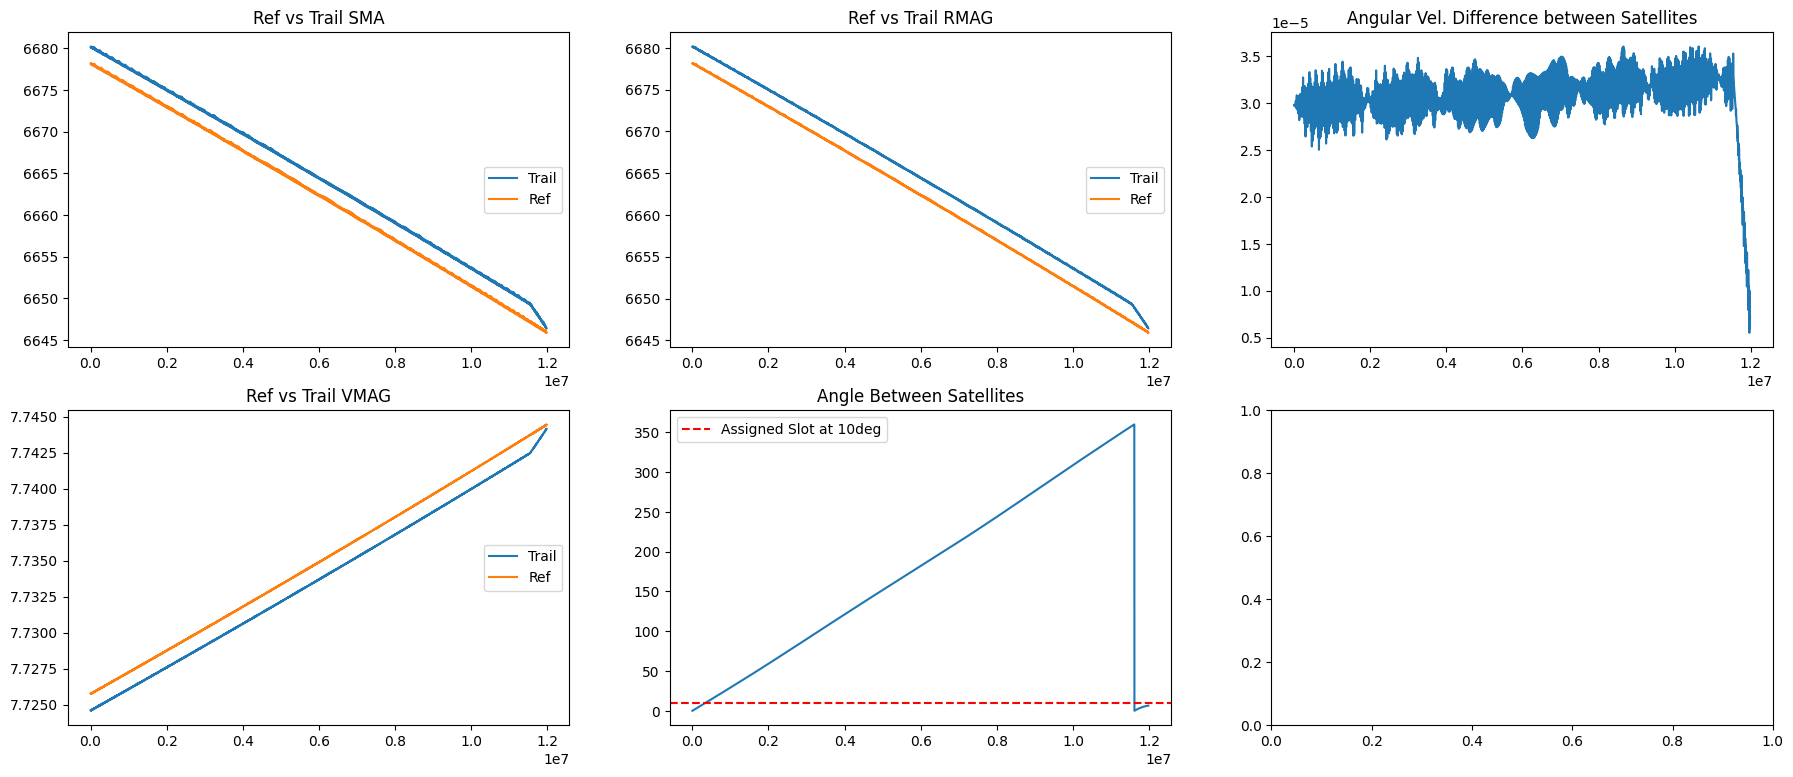

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(22,9), squeeze=False) 

ax[0,0].plot(elapsedsecs,trailsmalist,label='Trail')
ax[0,0].plot(elapsedsecs,refsmalist,label='Ref')
ax[0,0].legend(loc = 'center right')
ax[0,0].set_title('Ref vs Trail SMA')

ax[0,1].plot(elapsedsecs,rmag_trail,label='Trail')
ax[0,1].plot(elapsedsecs,rmag_ref,label='Ref')
ax[0,1].legend(loc = 'center right')
ax[0,1].set_title('Ref vs Trail RMAG')

ax[1,0].plot(elapsedsecs,vmag_trail,label='Trail')
ax[1,0].plot(elapsedsecs,vmag_ref, label='Ref')
ax[1,0].legend(loc = 'center right')
ax[1,0].set_title('Ref vs Trail VMAG')

# z = np.polyfit(elapsedsecs, angle_list, 1)
# p = np.poly1d(z)

ax[1,1].plot(elapsedsecs,angle_list)
# ax[1,1].plot(elapsedsecs,p(elapsedsecs))
ax[1,1].axhline(assignment,linestyle='--',color='red',label = f'Assigned Slot at {assignment}deg')
ax[1,1].legend(loc = 'upper left')
ax[1,1].set_title('Angle Between Satellites')

ax[0,2].plot(elapsedsecs,ang_vel_list)
ax[0,2].set_title('Angular Vel. Difference between Satellites')

# plt.show(block=True)

tic = time.time()
print(f'Timestep {time_step:.4f}s')
print(f'Run time {tic-toc:.2f}s/{(tic-toc)/60:.2f}m')
plt.show()